# Phase 2: Classical Baseline World Model

**Notebook:** `02_classical_baseline.ipynb`  
**Phase:** 2 of 9  
**Purpose:** Implement DreamerV3-style RSSM world model with classical training  
**Author:** Saurabh Jalendra  
**Institution:** BITS Pilani (WILP Division)  
**Date:** November 2025

---

## Table of Contents

1. [Setup & Imports](#1-setup--imports)
2. [World Model Architecture](#2-world-model-architecture)
3. [RSSM Implementation](#3-rssm-implementation)
4. [Training Components](#4-training-components)
5. [Replay Buffer](#5-replay-buffer)
6. [Training Loop](#6-training-loop)
7. [Experiments](#7-experiments)
8. [Visualizations](#8-visualizations)
9. [Save & Export](#9-save--export)

---
## 1. Setup & Imports

In [1]:
"""
Cell: Imports and Configuration
Purpose: Import all required packages and set up environment
"""

import os
import sys
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union, Any, NamedTuple
from dataclasses import dataclass, field
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical, OneHotCategorical
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler

# RL Environment
import gymnasium as gym

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Progress bar
from tqdm.notebook import tqdm

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import our utilities
from utils import set_seed, get_device, MetricLogger, timer

# Color palette
COLORS = {
    "baseline": "#2ecc71",
    "qaoa": "#3498db",
    "superposition": "#9b59b6",
    "gates": "#e74c3c",
    "error_correction": "#f39c12",
    "integrated": "#1abc9c",
}

# Configuration
SEED = 42
set_seed(SEED, deterministic=False)
DEVICE = get_device()

print(f"Device: {DEVICE}")
print(f"PyTorch: {torch.__version__}")
print(f"Gymnasium: {gym.__version__}")
print(f"Project Root: {PROJECT_ROOT}")

Device: cuda
PyTorch: 2.10.0.dev20251124+cu128
Gymnasium: 1.2.2
Project Root: c:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning


---
## 2. World Model Architecture

The world model follows the DreamerV3 RSSM architecture:
- **Encoder**: Converts observations to latent representations
- **RSSM**: Recurrent State-Space Model for temporal modeling
- **Dynamics Predictor**: Predicts next latent state
- **Reward Predictor**: Predicts rewards
- **Continue Predictor**: Predicts episode termination
- **Decoder**: Reconstructs observations from latent states

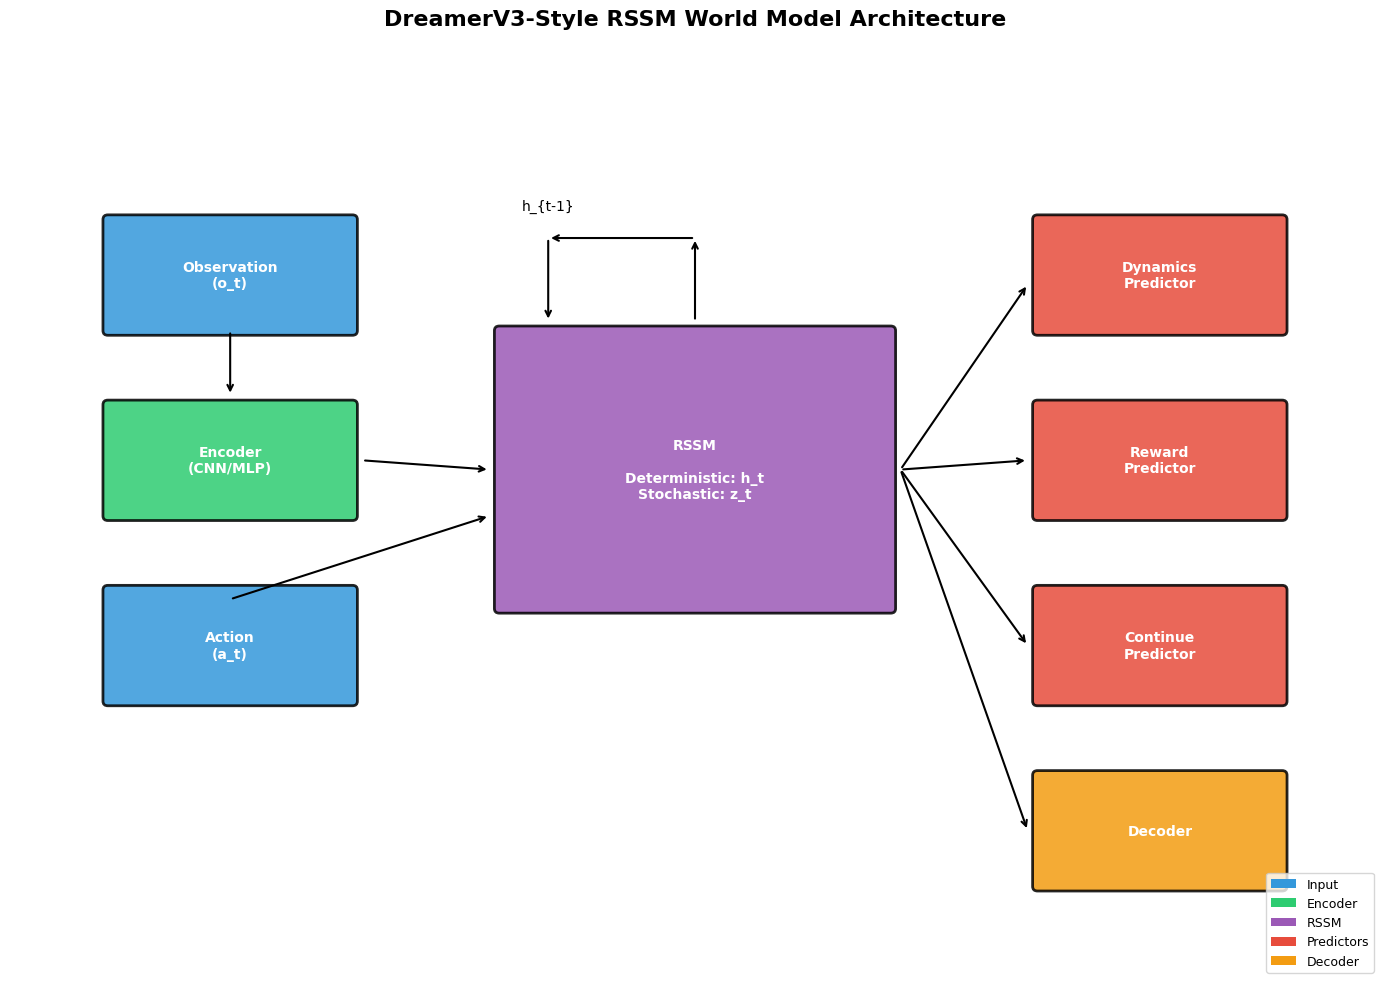

In [2]:
"""
Cell: Architecture Diagram
Purpose: Visualize the world model architecture
"""

def create_architecture_diagram(figsize: Tuple[int, int] = (14, 10)) -> plt.Figure:
    """
    Create a visual diagram of the RSSM world model architecture.
    
    Returns
    -------
    plt.Figure
        The matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Component colors
    colors = {
        'input': '#3498db',
        'encoder': '#2ecc71',
        'rssm': '#9b59b6',
        'predictor': '#e74c3c',
        'decoder': '#f39c12',
        'output': '#1abc9c',
    }
    
    # Draw components
    components = [
        # (x, y, w, h, label, color_key)
        (1, 7, 2.5, 1.2, 'Observation\n(o_t)', 'input'),
        (1, 5, 2.5, 1.2, 'Encoder\n(CNN/MLP)', 'encoder'),
        (5, 4, 4, 3, 'RSSM\n\nDeterministic: h_t\nStochastic: z_t', 'rssm'),
        (10.5, 7, 2.5, 1.2, 'Dynamics\nPredictor', 'predictor'),
        (10.5, 5, 2.5, 1.2, 'Reward\nPredictor', 'predictor'),
        (10.5, 3, 2.5, 1.2, 'Continue\nPredictor', 'predictor'),
        (10.5, 1, 2.5, 1.2, 'Decoder', 'decoder'),
        (1, 3, 2.5, 1.2, 'Action\n(a_t)', 'input'),
    ]
    
    for x, y, w, h, label, color_key in components:
        rect = mpatches.FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.05",
            facecolor=colors[color_key],
            edgecolor='black',
            linewidth=2,
            alpha=0.85
        )
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, label, ha='center', va='center',
               fontsize=10, fontweight='bold', color='white')
    
    # Draw arrows
    arrows = [
        ((2.25, 7), (2.25, 6.3)),  # obs -> encoder
        ((3.6, 5.6), (4.9, 5.5)),  # encoder -> rssm
        ((2.25, 4.1), (4.9, 5)),   # action -> rssm
        ((9.1, 5.5), (10.4, 7.5)), # rssm -> dynamics
        ((9.1, 5.5), (10.4, 5.6)), # rssm -> reward
        ((9.1, 5.5), (10.4, 3.6)), # rssm -> continue
        ((9.1, 5.5), (10.4, 1.6)), # rssm -> decoder
        ((7, 7.1), (7, 8)),        # rssm recurrence (up)
        ((7, 8), (5.5, 8)),        # recurrence (left)
        ((5.5, 8), (5.5, 7.1)),    # recurrence (down into rssm)
    ]
    
    for start, end in arrows:
        ax.annotate(
            '', xy=end, xytext=start,
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5)
        )
    
    # Labels
    ax.text(5.5, 8.3, 'h_{t-1}', fontsize=10, ha='center')
    
    ax.set_title('DreamerV3-Style RSSM World Model Architecture', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=colors['input'], label='Input'),
        mpatches.Patch(facecolor=colors['encoder'], label='Encoder'),
        mpatches.Patch(facecolor=colors['rssm'], label='RSSM'),
        mpatches.Patch(facecolor=colors['predictor'], label='Predictors'),
        mpatches.Patch(facecolor=colors['decoder'], label='Decoder'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    return fig


fig = create_architecture_diagram()
plt.tight_layout()
plt.show()

In [3]:
"""
Cell: Encoder Network
Purpose: Implement observation encoder (MLP for state-based environments)
"""

class MLPEncoder(nn.Module):
    """
    MLP encoder for state-based observations.
    
    Parameters
    ----------
    obs_dim : int
        Dimension of observation space
    hidden_dims : List[int]
        List of hidden layer dimensions
    latent_dim : int
        Dimension of latent representation
    activation : str
        Activation function ('relu', 'elu', 'tanh')
    """
    
    def __init__(
        self,
        obs_dim: int,
        hidden_dims: List[int] = [256, 256],
        latent_dim: int = 256,
        activation: str = 'elu'
    ):
        super().__init__()
        
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        
        # Build layers
        layers = []
        in_dim = obs_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, latent_dim))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize network weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.zeros_(m.bias)
    
    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        Encode observation to latent representation.
        
        Parameters
        ----------
        obs : torch.Tensor
            Observation tensor of shape (batch, obs_dim)
        
        Returns
        -------
        torch.Tensor
            Latent representation of shape (batch, latent_dim)
        """
        return self.network(obs)


# Test encoder
encoder = MLPEncoder(obs_dim=4, hidden_dims=[64, 64], latent_dim=32).to(DEVICE)
test_obs = torch.randn(8, 4, device=DEVICE)
test_latent = encoder(test_obs)
print(f"Encoder: {4} -> {test_latent.shape[-1]}")
print(f"Parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Encoder: 4 -> 32
Parameters: 6,560


In [4]:
"""
Cell: Decoder Network
Purpose: Implement observation decoder
"""

class MLPDecoder(nn.Module):
    """
    MLP decoder for reconstructing observations from latent states.
    
    Parameters
    ----------
    latent_dim : int
        Dimension of latent representation
    hidden_dims : List[int]
        List of hidden layer dimensions
    obs_dim : int
        Dimension of observation space
    activation : str
        Activation function
    """
    
    def __init__(
        self,
        latent_dim: int,
        hidden_dims: List[int] = [256, 256],
        obs_dim: int = 4,
        activation: str = 'elu'
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.obs_dim = obs_dim
        
        layers = []
        in_dim = latent_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, obs_dim))
        
        self.network = nn.Sequential(*layers)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.zeros_(m.bias)
    
    def forward(self, latent: torch.Tensor) -> torch.Tensor:
        """
        Decode latent representation to observation.
        
        Parameters
        ----------
        latent : torch.Tensor
            Latent tensor of shape (batch, latent_dim)
        
        Returns
        -------
        torch.Tensor
            Reconstructed observation of shape (batch, obs_dim)
        """
        return self.network(latent)


# Test decoder
decoder = MLPDecoder(latent_dim=32, hidden_dims=[64, 64], obs_dim=4).to(DEVICE)
test_recon = decoder(test_latent)
print(f"Decoder: {test_latent.shape[-1]} -> {test_recon.shape[-1]}")
print(f"Parameters: {sum(p.numel() for p in decoder.parameters()):,}")

Decoder: 32 -> 4
Parameters: 6,532


---
## 3. RSSM Implementation

The Recurrent State-Space Model (RSSM) is the core of the world model.
It maintains both deterministic (h) and stochastic (z) state components.

In [5]:
"""
Cell: RSSM State
Purpose: Define the RSSM state structure
"""

class RSSMState(NamedTuple):
    """
    RSSM state containing deterministic and stochastic components.
    
    Attributes
    ----------
    deter : torch.Tensor
        Deterministic state (hidden state from GRU)
    stoch : torch.Tensor
        Stochastic state (sampled from posterior/prior)
    """
    deter: torch.Tensor  # (batch, deter_dim)
    stoch: torch.Tensor  # (batch, stoch_dim)
    
    @property
    def combined(self) -> torch.Tensor:
        """Get combined state for downstream networks."""
        return torch.cat([self.deter, self.stoch], dim=-1)

In [6]:
"""
Cell: RSSM Core
Purpose: Implement the Recurrent State-Space Model
"""

class RSSM(nn.Module):
    """
    Recurrent State-Space Model for world model dynamics.
    
    Implements the DreamerV3-style RSSM with:
    - GRU for deterministic dynamics
    - Gaussian distributions for stochastic states
    
    Parameters
    ----------
    stoch_dim : int
        Dimension of stochastic state
    deter_dim : int
        Dimension of deterministic state
    hidden_dim : int
        Hidden dimension for MLPs
    action_dim : int
        Dimension of action space
    embed_dim : int
        Dimension of observation embedding
    """
    
    def __init__(
        self,
        stoch_dim: int = 32,
        deter_dim: int = 256,
        hidden_dim: int = 256,
        action_dim: int = 2,
        embed_dim: int = 256,
        min_std: float = 0.1
    ):
        super().__init__()
        
        self.stoch_dim = stoch_dim
        self.deter_dim = deter_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.embed_dim = embed_dim
        self.min_std = min_std
        
        # Input projection (action + stochastic -> hidden)
        self.input_proj = nn.Sequential(
            nn.Linear(stoch_dim + action_dim, hidden_dim),
            nn.ELU()
        )
        
        # Recurrent cell (GRU)
        self.gru = nn.GRUCell(hidden_dim, deter_dim)
        
        # Prior network (deterministic -> stochastic prior)
        self.prior_net = nn.Sequential(
            nn.Linear(deter_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * stoch_dim)  # mean and std
        )
        
        # Posterior network (deterministic + embed -> stochastic posterior)
        self.posterior_net = nn.Sequential(
            nn.Linear(deter_dim + embed_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * stoch_dim)  # mean and std
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GRUCell):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
    
    def initial_state(self, batch_size: int, device: torch.device) -> RSSMState:
        """
        Get initial RSSM state.
        
        Parameters
        ----------
        batch_size : int
            Batch size
        device : torch.device
            Device for tensors
        
        Returns
        -------
        RSSMState
            Initial state with zeros
        """
        return RSSMState(
            deter=torch.zeros(batch_size, self.deter_dim, device=device),
            stoch=torch.zeros(batch_size, self.stoch_dim, device=device)
        )
    
    def _get_dist(self, stats: torch.Tensor) -> Normal:
        """
        Get distribution from network output.
        
        Parameters
        ----------
        stats : torch.Tensor
            Network output of shape (batch, 2 * stoch_dim)
        
        Returns
        -------
        Normal
            Gaussian distribution
        """
        mean, std = torch.chunk(stats, 2, dim=-1)
        std = F.softplus(std) + self.min_std
        return Normal(mean, std)
    
    def imagine_step(
        self,
        prev_state: RSSMState,
        action: torch.Tensor
    ) -> Tuple[RSSMState, Normal]:
        """
        Imagine one step forward using prior (no observation).
        
        Parameters
        ----------
        prev_state : RSSMState
            Previous RSSM state
        action : torch.Tensor
            Action taken, shape (batch, action_dim)
        
        Returns
        -------
        Tuple[RSSMState, Normal]
            Next state and prior distribution
        """
        # Project input
        x = self.input_proj(torch.cat([prev_state.stoch, action], dim=-1))
        
        # Update deterministic state
        deter = self.gru(x, prev_state.deter)
        
        # Get prior distribution
        prior_stats = self.prior_net(deter)
        prior_dist = self._get_dist(prior_stats)
        
        # Sample stochastic state
        stoch = prior_dist.rsample()
        
        return RSSMState(deter=deter, stoch=stoch), prior_dist
    
    def observe_step(
        self,
        prev_state: RSSMState,
        action: torch.Tensor,
        embed: torch.Tensor
    ) -> Tuple[RSSMState, Normal, Normal]:
        """
        Observe one step forward using posterior (with observation).
        
        Parameters
        ----------
        prev_state : RSSMState
            Previous RSSM state
        action : torch.Tensor
            Action taken
        embed : torch.Tensor
            Observation embedding
        
        Returns
        -------
        Tuple[RSSMState, Normal, Normal]
            Next state, prior distribution, and posterior distribution
        """
        # Get prior prediction
        prior_state, prior_dist = self.imagine_step(prev_state, action)
        
        # Get posterior distribution using observation
        posterior_stats = self.posterior_net(
            torch.cat([prior_state.deter, embed], dim=-1)
        )
        posterior_dist = self._get_dist(posterior_stats)
        
        # Sample from posterior
        stoch = posterior_dist.rsample()
        
        return RSSMState(deter=prior_state.deter, stoch=stoch), prior_dist, posterior_dist


# Test RSSM
rssm = RSSM(
    stoch_dim=32,
    deter_dim=128,
    hidden_dim=128,
    action_dim=2,
    embed_dim=32
).to(DEVICE)

batch_size = 8
state = rssm.initial_state(batch_size, DEVICE)
action = torch.randn(batch_size, 2, device=DEVICE)
embed = torch.randn(batch_size, 32, device=DEVICE)

# Test imagine step
next_state, prior = rssm.imagine_step(state, action)
print(f"Imagine step - Deter: {next_state.deter.shape}, Stoch: {next_state.stoch.shape}")

# Test observe step
next_state, prior, posterior = rssm.observe_step(state, action, embed)
print(f"Observe step - Deter: {next_state.deter.shape}, Stoch: {next_state.stoch.shape}")
print(f"RSSM Parameters: {sum(p.numel() for p in rssm.parameters()):,}")

Imagine step - Deter: torch.Size([8, 128]), Stoch: torch.Size([8, 32])
Observe step - Deter: torch.Size([8, 128]), Stoch: torch.Size([8, 32])
RSSM Parameters: 157,184


In [7]:
"""
Cell: Predictor Networks
Purpose: Implement reward and continue predictors
"""

class RewardPredictor(nn.Module):
    """
    Predict rewards from RSSM state.
    
    Parameters
    ----------
    state_dim : int
        Combined RSSM state dimension (deter + stoch)
    hidden_dims : List[int]
        Hidden layer dimensions
    """
    
    def __init__(
        self,
        state_dim: int,
        hidden_dims: List[int] = [256, 256]
    ):
        super().__init__()
        
        layers = []
        in_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ELU()
            ])
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Predict reward from combined RSSM state."""
        return self.network(state).squeeze(-1)


class ContinuePredictor(nn.Module):
    """
    Predict episode continuation probability from RSSM state.
    
    Parameters
    ----------
    state_dim : int
        Combined RSSM state dimension
    hidden_dims : List[int]
        Hidden layer dimensions
    """
    
    def __init__(
        self,
        state_dim: int,
        hidden_dims: List[int] = [256, 256]
    ):
        super().__init__()
        
        layers = []
        in_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ELU()
            ])
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Predict continuation logit from combined RSSM state."""
        return self.network(state).squeeze(-1)


# Test predictors
state_dim = 128 + 32  # deter + stoch
reward_pred = RewardPredictor(state_dim, [64, 64]).to(DEVICE)
continue_pred = ContinuePredictor(state_dim, [64, 64]).to(DEVICE)

test_state = next_state.combined
pred_reward = reward_pred(test_state)
pred_continue = continue_pred(test_state)

print(f"Predicted reward shape: {pred_reward.shape}")
print(f"Predicted continue shape: {pred_continue.shape}")

Predicted reward shape: torch.Size([8])
Predicted continue shape: torch.Size([8])


---
## 4. Training Components

Implement the complete world model and loss functions.

In [8]:
"""
Cell: Complete World Model
Purpose: Combine all components into a complete world model
"""

class WorldModel(nn.Module):
    """
    Complete DreamerV3-style World Model.
    
    Combines encoder, RSSM, predictors, and decoder.
    
    Parameters
    ----------
    obs_dim : int
        Observation dimension
    action_dim : int
        Action dimension
    stoch_dim : int
        Stochastic state dimension
    deter_dim : int
        Deterministic state dimension
    hidden_dim : int
        Hidden layer dimension
    """
    
    def __init__(
        self,
        obs_dim: int,
        action_dim: int,
        stoch_dim: int = 32,
        deter_dim: int = 256,
        hidden_dim: int = 256,
        encoder_hidden: List[int] = [256, 256],
        decoder_hidden: List[int] = [256, 256],
        predictor_hidden: List[int] = [256, 256]
    ):
        super().__init__()
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.stoch_dim = stoch_dim
        self.deter_dim = deter_dim
        self.state_dim = stoch_dim + deter_dim
        
        # Encoder
        self.encoder = MLPEncoder(
            obs_dim=obs_dim,
            hidden_dims=encoder_hidden,
            latent_dim=hidden_dim
        )
        
        # RSSM
        self.rssm = RSSM(
            stoch_dim=stoch_dim,
            deter_dim=deter_dim,
            hidden_dim=hidden_dim,
            action_dim=action_dim,
            embed_dim=hidden_dim
        )
        
        # Predictors
        self.reward_predictor = RewardPredictor(
            state_dim=self.state_dim,
            hidden_dims=predictor_hidden
        )
        self.continue_predictor = ContinuePredictor(
            state_dim=self.state_dim,
            hidden_dims=predictor_hidden
        )
        
        # Decoder
        self.decoder = MLPDecoder(
            latent_dim=self.state_dim,
            hidden_dims=decoder_hidden,
            obs_dim=obs_dim
        )
    
    def initial_state(self, batch_size: int) -> RSSMState:
        """Get initial RSSM state."""
        device = next(self.parameters()).device
        return self.rssm.initial_state(batch_size, device)
    
    def observe(
        self,
        obs: torch.Tensor,
        action: torch.Tensor,
        prev_state: RSSMState
    ) -> Tuple[RSSMState, Normal, Normal]:
        """
        Process observation through the world model.
        
        Parameters
        ----------
        obs : torch.Tensor
            Observation tensor
        action : torch.Tensor
            Action tensor
        prev_state : RSSMState
            Previous RSSM state
        
        Returns
        -------
        Tuple[RSSMState, Normal, Normal]
            New state, prior, and posterior distributions
        """
        embed = self.encoder(obs)
        return self.rssm.observe_step(prev_state, action, embed)
    
    def imagine(
        self,
        action: torch.Tensor,
        prev_state: RSSMState
    ) -> Tuple[RSSMState, Normal]:
        """
        Imagine next state without observation.
        
        Parameters
        ----------
        action : torch.Tensor
            Action tensor
        prev_state : RSSMState
            Previous RSSM state
        
        Returns
        -------
        Tuple[RSSMState, Normal]
            New state and prior distribution
        """
        return self.rssm.imagine_step(prev_state, action)
    
    def predict(
        self,
        state: RSSMState
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Get predictions from RSSM state.
        
        Parameters
        ----------
        state : RSSMState
            Current RSSM state
        
        Returns
        -------
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            Reconstructed observation, predicted reward, predicted continue logit
        """
        combined = state.combined
        recon_obs = self.decoder(combined)
        pred_reward = self.reward_predictor(combined)
        pred_continue = self.continue_predictor(combined)
        return recon_obs, pred_reward, pred_continue
    
    def forward(
        self,
        obs_seq: torch.Tensor,
        action_seq: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Process a sequence of observations and actions.
        
        Parameters
        ----------
        obs_seq : torch.Tensor
            Observation sequence (batch, seq_len, obs_dim)
        action_seq : torch.Tensor
            Action sequence (batch, seq_len, action_dim)
        
        Returns
        -------
        Dict[str, torch.Tensor]
            Dictionary with predictions and distributions
        """
        batch_size, seq_len, _ = obs_seq.shape
        device = obs_seq.device
        
        # Initialize
        state = self.initial_state(batch_size)
        
        # Storage
        priors = []
        posteriors = []
        recon_obs_list = []
        pred_rewards = []
        pred_continues = []
        
        # Process sequence
        for t in range(seq_len):
            obs_t = obs_seq[:, t]
            action_t = action_seq[:, t]
            
            # Observe step
            state, prior, posterior = self.observe(obs_t, action_t, state)
            
            # Get predictions
            recon_obs, pred_reward, pred_continue = self.predict(state)
            
            # Store
            priors.append(prior)
            posteriors.append(posterior)
            recon_obs_list.append(recon_obs)
            pred_rewards.append(pred_reward)
            pred_continues.append(pred_continue)
        
        return {
            'recon_obs': torch.stack(recon_obs_list, dim=1),
            'pred_rewards': torch.stack(pred_rewards, dim=1),
            'pred_continues': torch.stack(pred_continues, dim=1),
            'priors': priors,
            'posteriors': posteriors,
        }


# Test world model
world_model = WorldModel(
    obs_dim=4,
    action_dim=2,
    stoch_dim=32,
    deter_dim=128,
    hidden_dim=128,
    encoder_hidden=[64, 64],
    decoder_hidden=[64, 64],
    predictor_hidden=[64, 64]
).to(DEVICE)

print(f"World Model Parameters: {sum(p.numel() for p in world_model.parameters()):,}")

# Test forward pass
batch_size, seq_len = 8, 20
test_obs_seq = torch.randn(batch_size, seq_len, 4, device=DEVICE)
test_action_seq = torch.randn(batch_size, seq_len, 2, device=DEVICE)

with torch.no_grad():
    output = world_model(test_obs_seq, test_action_seq)

print(f"Reconstructed obs shape: {output['recon_obs'].shape}")
print(f"Predicted rewards shape: {output['pred_rewards'].shape}")
print(f"Predicted continues shape: {output['pred_continues'].shape}")

World Model Parameters: 226,054
Reconstructed obs shape: torch.Size([8, 20, 4])
Predicted rewards shape: torch.Size([8, 20])
Predicted continues shape: torch.Size([8, 20])


In [9]:
"""
Cell: Loss Functions
Purpose: Implement world model training losses
"""

def compute_world_model_loss(
    model_output: Dict[str, torch.Tensor],
    obs_seq: torch.Tensor,
    reward_seq: torch.Tensor,
    continue_seq: torch.Tensor,
    kl_weight: float = 1.0,
    recon_weight: float = 1.0,
    reward_weight: float = 1.0,
    continue_weight: float = 1.0,
    free_nats: float = 1.0
) -> Dict[str, torch.Tensor]:
    """
    Compute world model training loss.
    
    Parameters
    ----------
    model_output : Dict[str, torch.Tensor]
        Output from world model forward pass
    obs_seq : torch.Tensor
        Ground truth observations (batch, seq_len, obs_dim)
    reward_seq : torch.Tensor
        Ground truth rewards (batch, seq_len)
    continue_seq : torch.Tensor
        Ground truth continue flags (batch, seq_len)
    kl_weight : float
        Weight for KL divergence loss
    recon_weight : float
        Weight for reconstruction loss
    reward_weight : float
        Weight for reward prediction loss
    continue_weight : float
        Weight for continue prediction loss
    free_nats : float
        Free nats for KL loss (minimum KL)
    
    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary with individual losses and total loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(model_output['recon_obs'], obs_seq)
    
    # Reward prediction loss (MSE)
    reward_loss = F.mse_loss(model_output['pred_rewards'], reward_seq)
    
    # Continue prediction loss (BCE with logits)
    continue_loss = F.binary_cross_entropy_with_logits(
        model_output['pred_continues'],
        continue_seq
    )
    
    # KL divergence loss
    kl_losses = []
    for prior, posterior in zip(model_output['priors'], model_output['posteriors']):
        kl = torch.distributions.kl_divergence(posterior, prior).sum(-1)
        kl = torch.clamp(kl, min=free_nats).mean()
        kl_losses.append(kl)
    kl_loss = torch.stack(kl_losses).mean()
    
    # Total loss
    total_loss = (
        kl_weight * kl_loss +
        recon_weight * recon_loss +
        reward_weight * reward_loss +
        continue_weight * continue_loss
    )
    
    return {
        'total': total_loss,
        'kl': kl_loss,
        'recon': recon_loss,
        'reward': reward_loss,
        'continue': continue_loss
    }


# Test loss computation
test_rewards = torch.randn(batch_size, seq_len, device=DEVICE)
test_continues = torch.ones(batch_size, seq_len, device=DEVICE)

losses = compute_world_model_loss(
    output, test_obs_seq, test_rewards, test_continues
)

print("Loss components:")
for name, value in losses.items():
    print(f"  {name}: {value.item():.4f}")

Loss components:
  total: 7.2212
  kl: 3.3988
  recon: 2.2534
  reward: 0.8248
  continue: 0.7442


---
## 5. Replay Buffer

In [10]:
"""
Cell: Replay Buffer
Purpose: Implement experience replay buffer for training
"""

@dataclass
class Episode:
    """
    Container for a single episode of experience.
    
    Attributes
    ----------
    observations : np.ndarray
        Array of observations (T, obs_dim)
    actions : np.ndarray
        Array of actions (T, action_dim)
    rewards : np.ndarray
        Array of rewards (T,)
    dones : np.ndarray
        Array of done flags (T,)
    """
    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    dones: np.ndarray
    
    def __len__(self) -> int:
        return len(self.observations)


class ReplayBuffer:
    """
    Replay buffer for storing and sampling episodes.
    
    Parameters
    ----------
    capacity : int
        Maximum number of episodes to store
    """
    
    def __init__(self, capacity: int = 1000):
        self.capacity = capacity
        self.episodes: List[Episode] = []
        self.total_steps = 0
    
    def add_episode(self, episode: Episode) -> None:
        """
        Add an episode to the buffer.
        
        Parameters
        ----------
        episode : Episode
            Episode to add
        """
        if len(self.episodes) >= self.capacity:
            removed = self.episodes.pop(0)
            self.total_steps -= len(removed)
        
        self.episodes.append(episode)
        self.total_steps += len(episode)
    
    def sample_sequences(
        self,
        batch_size: int,
        seq_len: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Sample random sequences from episodes.
        
        Parameters
        ----------
        batch_size : int
            Number of sequences to sample
        seq_len : int
            Length of each sequence
        
        Returns
        -------
        Tuple[np.ndarray, ...]
            (observations, actions, rewards, continues)
        """
        # Filter episodes that are long enough
        valid_episodes = [ep for ep in self.episodes if len(ep) >= seq_len]
        
        if not valid_episodes:
            raise ValueError(f"No episodes with length >= {seq_len}")
        
        obs_batch = []
        action_batch = []
        reward_batch = []
        continue_batch = []
        
        for _ in range(batch_size):
            # Random episode
            episode = valid_episodes[np.random.randint(len(valid_episodes))]
            
            # Random start position
            max_start = len(episode) - seq_len
            start = np.random.randint(0, max_start + 1)
            
            # Extract sequence
            obs_batch.append(episode.observations[start:start + seq_len])
            action_batch.append(episode.actions[start:start + seq_len])
            reward_batch.append(episode.rewards[start:start + seq_len])
            # Continue is 1 - done
            continue_batch.append(1.0 - episode.dones[start:start + seq_len])
        
        return (
            np.stack(obs_batch),
            np.stack(action_batch),
            np.stack(reward_batch),
            np.stack(continue_batch)
        )
    
    def __len__(self) -> int:
        return len(self.episodes)


def collect_episodes(
    env_name: str,
    num_episodes: int = 100,
    seed: int = 42
) -> List[Episode]:
    """
    Collect episodes from an environment using random actions.
    
    Parameters
    ----------
    env_name : str
        Gymnasium environment name
    num_episodes : int
        Number of episodes to collect
    seed : int
        Random seed
    
    Returns
    -------
    List[Episode]
        List of collected episodes
    """
    env = gym.make(env_name)
    episodes = []
    
    for ep_idx in tqdm(range(num_episodes), desc="Collecting episodes"):
        obs_list = []
        action_list = []
        reward_list = []
        done_list = []
        
        obs, _ = env.reset(seed=seed + ep_idx)
        done = False
        
        while not done:
            action = env.action_space.sample()
            
            # Store current transition
            obs_list.append(obs)
            
            # Handle discrete actions - convert to one-hot for network
            if isinstance(env.action_space, gym.spaces.Discrete):
                action_onehot = np.zeros(env.action_space.n)
                action_onehot[action] = 1.0
                action_list.append(action_onehot)
            else:
                action_list.append(action)
            
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            reward_list.append(reward)
            done_list.append(float(done))
        
        episodes.append(Episode(
            observations=np.array(obs_list, dtype=np.float32),
            actions=np.array(action_list, dtype=np.float32),
            rewards=np.array(reward_list, dtype=np.float32),
            dones=np.array(done_list, dtype=np.float32)
        ))
    
    env.close()
    return episodes


# Collect episodes from CartPole
print("Collecting training data...")
episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)

# Create replay buffer
replay_buffer = ReplayBuffer(capacity=1000)
for ep in episodes:
    replay_buffer.add_episode(ep)

print(f"Buffer size: {len(replay_buffer)} episodes, {replay_buffer.total_steps} steps")

# Test sampling
obs, actions, rewards, continues = replay_buffer.sample_sequences(batch_size=8, seq_len=20)
print(f"Sample shapes: obs={obs.shape}, actions={actions.shape}, rewards={rewards.shape}")

Buffer size: 100 episodes, 2132 steps
Sample shapes: obs=(8, 20, 4), actions=(8, 20, 2), rewards=(8, 20)


---
## 6. Training Loop

In [11]:
"""
Cell: Trainer Class
Purpose: Implement the training loop for the world model
"""

class WorldModelTrainer:
    """
    Trainer for the world model.
    
    Parameters
    ----------
    model : WorldModel
        World model to train
    replay_buffer : ReplayBuffer
        Replay buffer with episodes
    lr : float
        Learning rate
    grad_clip : float
        Gradient clipping value
    device : torch.device
        Device for training
    use_amp : bool
        Whether to use mixed precision training
    """
    
    def __init__(
        self,
        model: WorldModel,
        replay_buffer: ReplayBuffer,
        lr: float = 1e-3,
        weight_decay: float = 0.01,
        grad_clip: float = 100.0,
        device: torch.device = DEVICE,
        use_amp: bool = True
    ):
        self.model = model
        self.replay_buffer = replay_buffer
        self.device = device
        self.grad_clip = grad_clip
        self.use_amp = use_amp and device.type == "cuda"
        self.amp_dtype = torch.bfloat16
        
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=lr,
            weight_decay=weight_decay,
            fused=True if device.type == "cuda" else False
        )
        
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=1000, T_mult=2
        )
        
        self.scaler = GradScaler('cuda', enabled=False)
        self.logger = MetricLogger(name="world_model")
    
    def train_step(
        self,
        batch_size: int = 256,
        seq_len: int = 50,
        kl_weight: float = 1.0
    ) -> Dict[str, float]:
        """
        Perform a single training step.
        
        Parameters
        ----------
        batch_size : int
            Batch size
        seq_len : int
            Sequence length
        kl_weight : float
            Weight for KL loss
        
        Returns
        -------
        Dict[str, float]
            Dictionary with loss values
        """
        self.model.train()
        
        # Sample batch
        obs, actions, rewards, continues = self.replay_buffer.sample_sequences(
            batch_size, seq_len
        )
        
        # Convert to tensors
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.float32, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        continues = torch.tensor(continues, dtype=torch.float32, device=self.device)
        
        # Forward pass
        self.optimizer.zero_grad(set_to_none=True)
        
        with autocast(device_type='cuda', dtype=self.amp_dtype, enabled=self.use_amp):
            output = self.model(obs, actions)
            losses = compute_world_model_loss(
                output, obs, rewards, continues, kl_weight=kl_weight
            )
        
        # Backward pass
        losses['total'].backward()
        grad_norm = nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
        self.optimizer.step()
        self.scheduler.step()
        
        # Log
        result = {k: v.item() for k, v in losses.items()}
        result['grad_norm'] = grad_norm.item() if isinstance(grad_norm, torch.Tensor) else grad_norm
        
        self.logger.log(**result)
        
        return result
    
    def train(
        self,
        num_steps: int = 10000,
        batch_size: int = 256,
        seq_len: int = 50,
        log_every: int = 100,
        kl_weight: float = 1.0
    ) -> pd.DataFrame:
        """
        Train the world model.
        
        Parameters
        ----------
        num_steps : int
            Number of training steps
        batch_size : int
            Batch size
        seq_len : int
            Sequence length
        log_every : int
            Log every N steps
        kl_weight : float
            Weight for KL loss
        
        Returns
        -------
        pd.DataFrame
            Training history
        """
        pbar = tqdm(range(num_steps), desc="Training")
        
        for step in pbar:
            losses = self.train_step(batch_size, seq_len, kl_weight)
            
            if step % log_every == 0:
                pbar.set_postfix({
                    'total': f"{self.logger.get_mean('total', 100):.4f}",
                    'recon': f"{self.logger.get_mean('recon', 100):.4f}",
                    'kl': f"{self.logger.get_mean('kl', 100):.4f}"
                })
        
        return self.logger.to_dataframe()


print("Trainer class defined.")

Trainer class defined.


---
## 7. Experiments

In [12]:
"""
Cell: CartPole Experiment
Purpose: Train world model on CartPole-v1
"""

# Create world model for CartPole
cartpole_model = WorldModel(
    obs_dim=4,
    action_dim=2,
    stoch_dim=64,
    deter_dim=512,
    hidden_dim=512,
    encoder_hidden=[512, 512],
    decoder_hidden=[512, 512],
    predictor_hidden=[512, 512]
).to(DEVICE)

print(f"CartPole World Model Parameters: {sum(p.numel() for p in cartpole_model.parameters()):,}")

# Create trainer
trainer = WorldModelTrainer(
    model=cartpole_model,
    replay_buffer=replay_buffer,
    lr=1e-3,
    grad_clip=100.0,
    device=DEVICE
)

# Train
print("\nTraining on CartPole-v1...")
history = trainer.train(
    num_steps=10000,
    batch_size=256,
    seq_len=50,
    log_every=100,
    kl_weight=1.0
)

print(f"\nTraining complete! Final losses:")
print(f"  Total: {history['total'].iloc[-100:].mean():.4f}")
print(f"  Recon: {history['recon'].iloc[-100:].mean():.4f}")
print(f"  KL: {history['kl'].iloc[-100:].mean():.4f}")

CartPole World Model Parameters: 4,734,214

Training on CartPole-v1...


Training:   0%|          | 0/10000 [00:00<?, ?it/s]


Training complete! Final losses:
  Total: 1.0101
  Recon: 0.0080
  KL: 1.0003


---
## 8. Visualizations

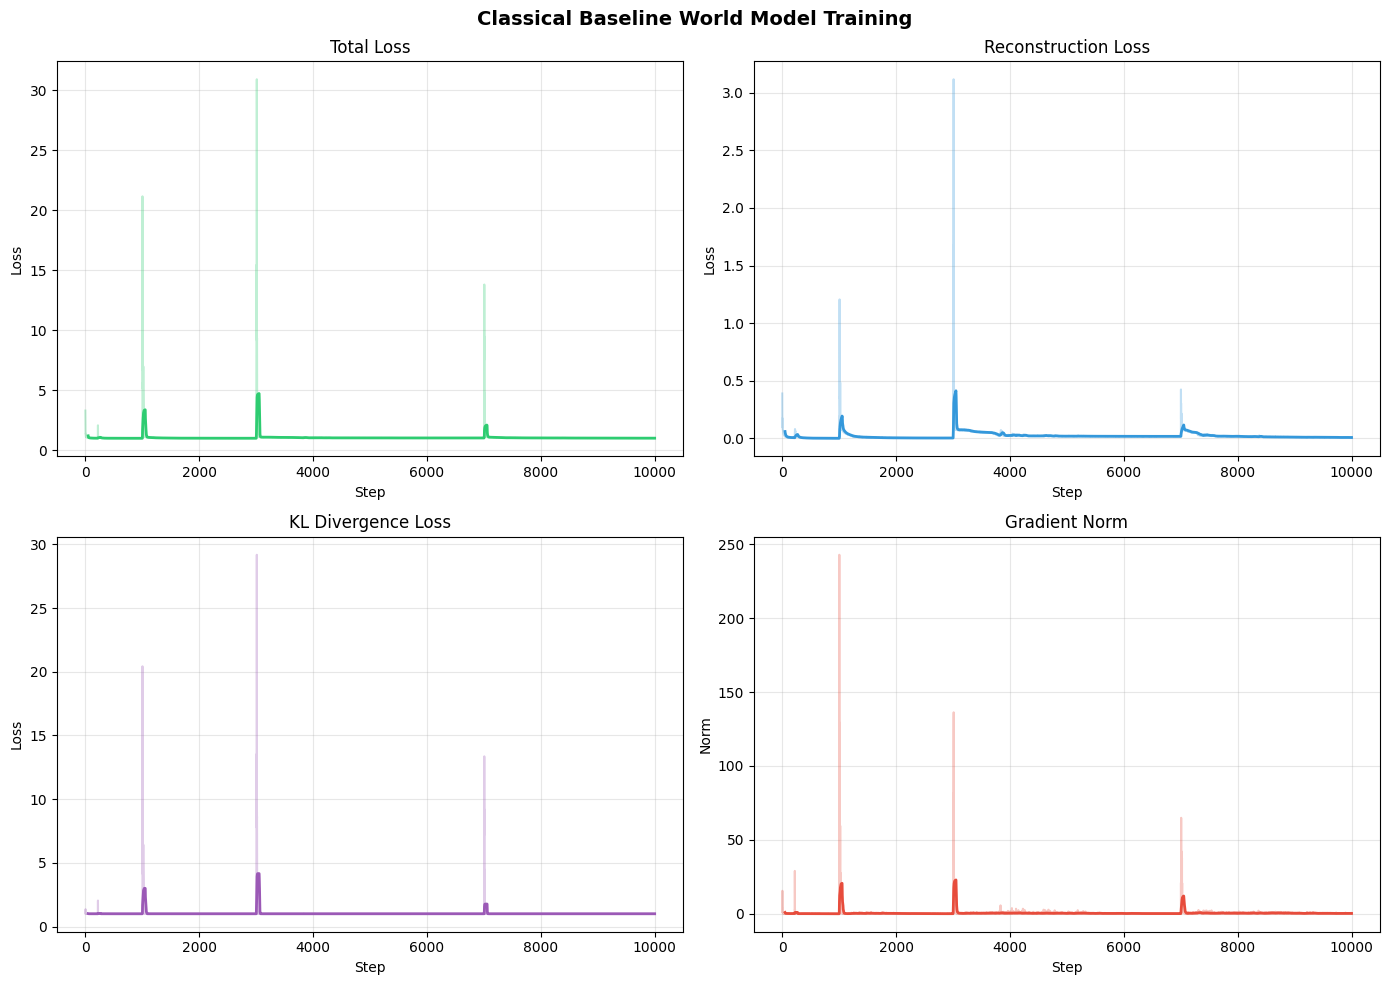

In [13]:
"""
Cell: Loss Curves
Purpose: Plot training loss curves
"""

def plot_training_curves(history: pd.DataFrame, figsize: Tuple[int, int] = (14, 10)):
    """
    Plot training loss curves.
    
    Parameters
    ----------
    history : pd.DataFrame
        Training history from trainer
    figsize : Tuple[int, int]
        Figure size
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Smoothing window
    window = 50
    
    # Total loss
    ax = axes[0, 0]
    ax.plot(history['total'], alpha=0.3, color=COLORS['baseline'])
    ax.plot(history['total'].rolling(window).mean(), color=COLORS['baseline'], linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Total Loss')
    ax.grid(True, alpha=0.3)
    
    # Reconstruction loss
    ax = axes[0, 1]
    ax.plot(history['recon'], alpha=0.3, color=COLORS['qaoa'])
    ax.plot(history['recon'].rolling(window).mean(), color=COLORS['qaoa'], linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Reconstruction Loss')
    ax.grid(True, alpha=0.3)
    
    # KL loss
    ax = axes[1, 0]
    ax.plot(history['kl'], alpha=0.3, color=COLORS['superposition'])
    ax.plot(history['kl'].rolling(window).mean(), color=COLORS['superposition'], linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('KL Divergence Loss')
    ax.grid(True, alpha=0.3)
    
    # Gradient norm
    ax = axes[1, 1]
    ax.plot(history['grad_norm'], alpha=0.3, color=COLORS['gates'])
    ax.plot(history['grad_norm'].rolling(window).mean(), color=COLORS['gates'], linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel('Norm')
    ax.set_title('Gradient Norm')
    ax.grid(True, alpha=0.3)
    
    fig.suptitle('Classical Baseline World Model Training', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig


fig = plot_training_curves(history)
plt.show()

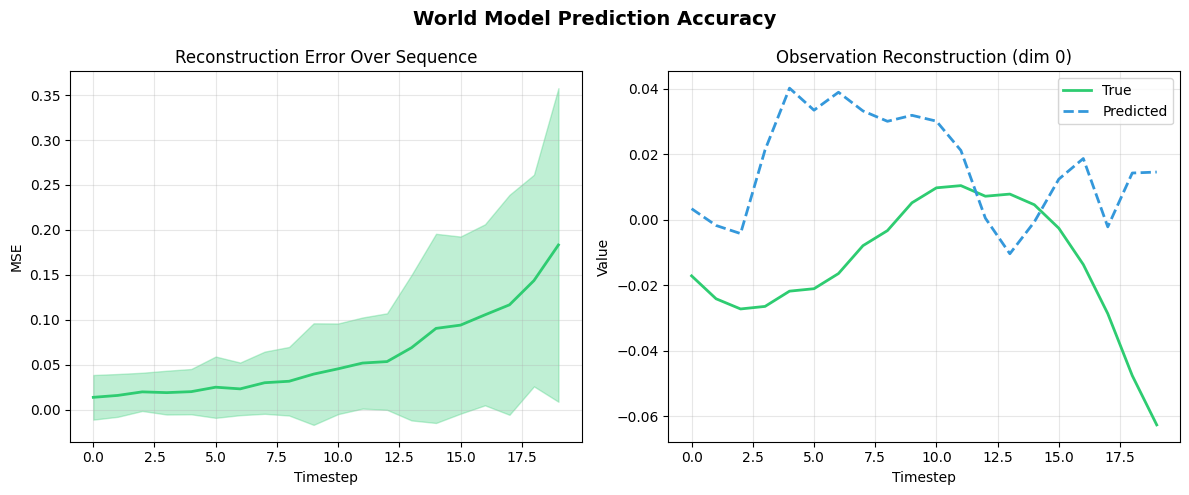

Mean reconstruction error: 0.059471
Mean reward prediction error: 0.000002


In [14]:
"""
Cell: Prediction Accuracy
Purpose: Evaluate and visualize prediction accuracy
"""

def evaluate_predictions(model: WorldModel, buffer: ReplayBuffer, num_samples: int = 100):
    """
    Evaluate world model prediction accuracy.
    
    Parameters
    ----------
    model : WorldModel
        Trained world model
    buffer : ReplayBuffer
        Replay buffer with test data
    num_samples : int
        Number of samples to evaluate
    
    Returns
    -------
    Dict[str, np.ndarray]
        Dictionary with evaluation results
    """
    model.eval()
    
    # Sample test data
    obs, actions, rewards, continues = buffer.sample_sequences(num_samples, seq_len=20)
    
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    
    with torch.no_grad():
        output = model(obs, actions)
    
    # Compute errors
    recon_error = (output['recon_obs'] - obs).pow(2).mean(dim=-1).cpu().numpy()
    reward_error = (output['pred_rewards'].cpu().numpy() - rewards) ** 2
    
    return {
        'recon_error': recon_error,
        'reward_error': reward_error,
        'true_obs': obs.cpu().numpy(),
        'pred_obs': output['recon_obs'].cpu().numpy(),
    }


# Evaluate
eval_results = evaluate_predictions(cartpole_model, replay_buffer)

# Plot prediction accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Reconstruction error over sequence
ax = axes[0]
mean_error = eval_results['recon_error'].mean(axis=0)
std_error = eval_results['recon_error'].std(axis=0)
x = np.arange(len(mean_error))

ax.plot(x, mean_error, color=COLORS['baseline'], linewidth=2)
ax.fill_between(x, mean_error - std_error, mean_error + std_error, 
               color=COLORS['baseline'], alpha=0.3)
ax.set_xlabel('Timestep')
ax.set_ylabel('MSE')
ax.set_title('Reconstruction Error Over Sequence')
ax.grid(True, alpha=0.3)

# True vs Predicted observation (single dimension)
ax = axes[1]
sample_idx = 0
dim_idx = 0
true = eval_results['true_obs'][sample_idx, :, dim_idx]
pred = eval_results['pred_obs'][sample_idx, :, dim_idx]

ax.plot(true, label='True', color=COLORS['baseline'], linewidth=2)
ax.plot(pred, label='Predicted', color=COLORS['qaoa'], linestyle='--', linewidth=2)
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')
ax.set_title(f'Observation Reconstruction (dim {dim_idx})')
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('World Model Prediction Accuracy', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Mean reconstruction error: {eval_results['recon_error'].mean():.6f}")
print(f"Mean reward prediction error: {eval_results['reward_error'].mean():.6f}")

Running t-SNE...


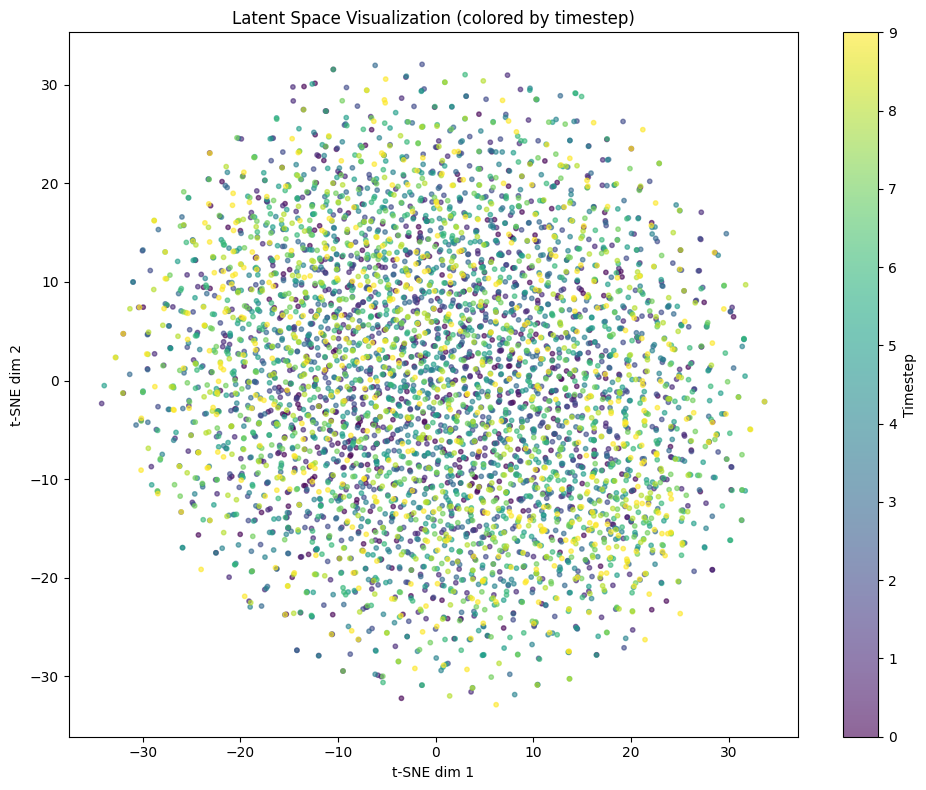

In [15]:
"""
Cell: Latent Space Visualization
Purpose: Visualize latent representations using t-SNE
"""

from sklearn.manifold import TSNE

def visualize_latent_space(
    model: WorldModel,
    buffer: ReplayBuffer,
    num_samples: int = 500
):
    """
    Visualize latent representations using t-SNE.
    
    Parameters
    ----------
    model : WorldModel
        Trained world model
    buffer : ReplayBuffer
        Replay buffer
    num_samples : int
        Number of samples
    """
    model.eval()
    
    # Sample data
    obs, actions, rewards, continues = buffer.sample_sequences(num_samples, seq_len=10)
    
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    
    # Get latent representations
    latents = []
    timesteps = []
    
    with torch.no_grad():
        batch_size = obs.shape[0]
        state = model.initial_state(batch_size)
        
        for t in range(obs.shape[1]):
            state, _, _ = model.observe(obs[:, t], actions[:, t], state)
            latents.append(state.combined.cpu().numpy())
            timesteps.extend([t] * batch_size)
    
    latents = np.concatenate(latents, axis=0)
    timesteps = np.array(timesteps)
    
    # Apply t-SNE
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=SEED)
    latents_2d = tsne.fit_transform(latents)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    scatter = ax.scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=timesteps, cmap='viridis',
        alpha=0.6, s=10
    )
    
    plt.colorbar(scatter, label='Timestep')
    ax.set_xlabel('t-SNE dim 1')
    ax.set_ylabel('t-SNE dim 2')
    ax.set_title('Latent Space Visualization (colored by timestep)')
    
    plt.tight_layout()
    return fig


fig = visualize_latent_space(cartpole_model, replay_buffer)
plt.show()

---
## 9. Save & Export

In [ ]:
"""
Cell: Save Model
Purpose: Save trained model and training history
"""

# Create results directory
results_dir = PROJECT_ROOT / "experiments" / "results" / "baseline"
results_dir.mkdir(parents=True, exist_ok=True)

# Save model checkpoint with CORRECT config matching Cell 19
checkpoint = {
    'model_state_dict': cartpole_model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'config': {
        # Environment
        'obs_dim': 4,
        'action_dim': 2,
        # RSSM dimensions (FIXED - matches Cell 19)
        'stoch_dim': 64,
        'deter_dim': 512,
        'hidden_dim': 512,
        # Network architectures (ADDED)
        'encoder_hidden': [512, 512],
        'decoder_hidden': [512, 512],
        'predictor_hidden': [512, 512],
        # Training config
        'learning_rate': 1e-3,
        'batch_size': 256,
        'seq_len': 50,
        'kl_weight': 1.0,
    },
    'training_steps': len(history),
    'final_loss': history['total'].iloc[-100:].mean(),
    'final_recon_loss': history['recon'].iloc[-100:].mean(),
    'final_kl_loss': history['kl'].iloc[-100:].mean(),
}

checkpoint_path = results_dir / "cartpole_baseline.pt"
torch.save(checkpoint, checkpoint_path)
print(f"Model saved to: {checkpoint_path}")

# Save training history
history_path = results_dir / "cartpole_training_history.csv"
history.to_csv(history_path, index=False)
print(f"Training history saved to: {history_path}")

# Verify saved config
print(f"\nSaved config:")
for key, value in checkpoint['config'].items():
    print(f"  {key}: {value}")

In [17]:
"""
Cell: Summary
Purpose: Display training summary and next steps
"""

print("=" * 60)
print("PHASE 2 COMPLETE: CLASSICAL BASELINE WORLD MODEL")
print("=" * 60)

print("\n[1] Components Implemented")
print("    - MLPEncoder: Observation to latent")
print("    - MLPDecoder: Latent to observation")
print("    - RSSM: Recurrent State-Space Model")
print("    - RewardPredictor: State to reward")
print("    - ContinuePredictor: State to continue probability")
print("    - WorldModel: Complete model combining all components")

print("\n[2] Training")
print(f"    - Environment: CartPole-v1")
print(f"    - Training steps: {len(history)}")
print(f"    - Final total loss: {history['total'].iloc[-100:].mean():.4f}")
print(f"    - Final recon loss: {history['recon'].iloc[-100:].mean():.6f}")
print(f"    - Model parameters: {sum(p.numel() for p in cartpole_model.parameters()):,}")

print("\n[3] Files Saved")
print(f"    - Model: {checkpoint_path}")
print(f"    - History: {history_path}")

print("\n" + "=" * 60)
print("NEXT STEPS: Phase 3 - QAOA-Enhanced Training")
print("=" * 60)
print("""
In Phase 3, we will:
  1. Implement QAOA-inspired optimizer
  2. Add cost and mixing operators
  3. Create alternating optimization schedule
  4. Compare with classical baseline
  5. Visualize optimization trajectory
""")

PHASE 2 COMPLETE: CLASSICAL BASELINE WORLD MODEL

[1] Components Implemented
    - MLPEncoder: Observation to latent
    - MLPDecoder: Latent to observation
    - RSSM: Recurrent State-Space Model
    - RewardPredictor: State to reward
    - ContinuePredictor: State to continue probability
    - WorldModel: Complete model combining all components

[2] Training
    - Environment: CartPole-v1
    - Training steps: 10000
    - Final total loss: 1.0101
    - Final recon loss: 0.008039
    - Model parameters: 4,734,214

[3] Files Saved
    - Model: c:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\experiments\results\baseline\cartpole_baseline.pt
    - History: c:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\experiments\results\baseline\cartpole_training_history.csv

NEXT STEPS: Phase 3 - QAOA-Enhanced Training

In Phase 3, we will:
  1. Implement QAOA-inspired optimizer
  2. Add cost and mixing operators
  3. Create alternating optimi